<a href="https://colab.research.google.com/github/dhy02094/pytorch/blob/master/pytorch%EB%A1%9C_%EB%B2%8C%EA%B3%BC_%EA%B0%9C_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /content/drive/MyDrive/pytorch/1_image_classfication

/content/drive/MyDrive/pytorch/1_image_classfication


In [2]:
import tqdm

In [3]:
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

# 난수 설정
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [4]:
from torchvision.transforms.transforms import RandomHorizontalFlip
# 입력 화상의 전처리 클래스

class ImageTransform():
    """
    화상 전처리 클래스. 훈련시, 검증 시의 동작이 다르다.
    화상 크기를 리사이즈하고 색상을 표준화한다.
    훈련시에는 RandomResizedCrop과 RandomHorizontalFlip으로 데이터를 확장한다.
    
    resize : int
        리사이즈 대상 화상의 크기
    mean : (R,G,B)
        각 색상 채널의 평균값
    std : (R,G,B)
        각 색상 채널의 표준편차
    """

    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(
                    resize, scale=(0.5, 1.0)),  #데이터 확장
                transforms.RandomHorizontalFlip(),  #데이터 확장
                transforms.ToTensor(),         # 텐서로 변환
                transforms.Normalize(mean,std) # 표준화
            ]),
            'val' : transforms.Compose([
                transforms.Resize(resize),       #리사이즈
                transforms.CenterCrop(resize),   # 화상 중앙을 resize*resize로 자른다.
                transforms.ToTensor(),           # 텐서로 변환
                transforms.Normalize(mean,std)   # 표준화
            ])
        }


    def __call__(self, img, phase='train'):
        """
        Parameters
        ----------
        phase : 'train' or 'val' 설정
        """

        return self.data_transform[phase](img)


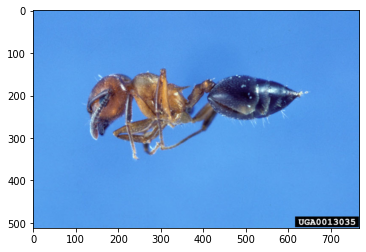

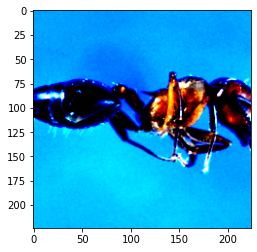

In [5]:
# 위 클래스 사용해보기

# 1. 화상 읽기
image_file_path = '/content/drive/MyDrive/pytorch/1_image_classfication/data/hymenoptera_data/train/ants/0013035.jpg'
img = Image.open(image_file_path)

# 2. 원본 사진 표시
plt.imshow(img)
plt.show()

# 3. 화상 전처리, 처리된 화상 표시
size = 224
mean = (0.485,0.456,0.406)
std = (0.229,0.224,0.225)

transform = ImageTransform(size,mean,std)
img_transformed = transform(img,phase='train') # torch.Size([3,224,224]) 토치 종특

# (c, h, w) -> (h,w,c) and 0-1 값으로 제한
img_transformed = img_transformed.numpy().transpose(1,2,0)  # 1,2,0 순서로 보낸다
img_transformed = np.clip(img_transformed,0,1)
plt.imshow(img_transformed)
plt.show()


>실행할 때마다 사진이 확장되고 반전되고 결과가 변한다.

In [6]:
# 개미와 벌이 담긴 사진 파일의 경로 리스트 작성
def make_datapath_list(phase='train'):
    rootpath='/content/drive/MyDrive/pytorch/1_image_classfication/data/hymenoptera_data/'
    target_path = osp.join(rootpath+phase+'/**/*.jpg')
    print(target_path)

    path_list = []

    for path in glob.glob(target_path):
        path_list.append(path)

    return path_list

In [7]:
train_list = make_datapath_list(phase='train')
val_list = make_datapath_list(phase='val')

train_list

/content/drive/MyDrive/pytorch/1_image_classfication/data/hymenoptera_data/train/**/*.jpg
/content/drive/MyDrive/pytorch/1_image_classfication/data/hymenoptera_data/val/**/*.jpg


['/content/drive/MyDrive/pytorch/1_image_classfication/data/hymenoptera_data/train/ants/0013035.jpg',
 '/content/drive/MyDrive/pytorch/1_image_classfication/data/hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg',
 '/content/drive/MyDrive/pytorch/1_image_classfication/data/hymenoptera_data/train/ants/1095476100_3906d8afde.jpg',
 '/content/drive/MyDrive/pytorch/1_image_classfication/data/hymenoptera_data/train/ants/1099452230_d1949d3250.jpg',
 '/content/drive/MyDrive/pytorch/1_image_classfication/data/hymenoptera_data/train/ants/116570827_e9c126745d.jpg',
 '/content/drive/MyDrive/pytorch/1_image_classfication/data/hymenoptera_data/train/ants/1225872729_6f0856588f.jpg',
 '/content/drive/MyDrive/pytorch/1_image_classfication/data/hymenoptera_data/train/ants/1262877379_64fcada201.jpg',
 '/content/drive/MyDrive/pytorch/1_image_classfication/data/hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg',
 '/content/drive/MyDrive/pytorch/1_image_classfication/data/hymenoptera_data/train/ants

In [8]:
# 개미와 벌의 사진에 대한 Dataset 작성

class HymenopteraDataset(data.Dataset):
    """
    개미와 벌 사진의 dataset 클래스. 파이토치의 dataset 클래스 상속

    Attributes
    -----------
    file_list : 리스트
        사진 경로를 저장한 리스트
    transform : object
        전처리 클래스의 인스턴스
    phase : 'train' or 'test'
        학습인지 훈련인지 설정
    """

    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list # 파일 경로 리스트
        self.transform = transform # 전처리 클래스의 인스턴스
        self.phase = phase # 학습인지, 훈련인지

    def __len__(self):
        """사진 개수를 반환"""
        return len(self.file_list)

    def __getitem__(self, index):
        """
        전처리한 사진의 텐서 형식의 데이터와 라벨 취득
        """

        # index번째의 화상 로드
        img_path = self.file_list[index]
        img = Image.open(img_path)  # 높이, 폭, 채널
        
        # img 전처리 실시
        img_transformed = self.transform(
            img, self.phase)  # 3,224,224
        
        # 사진 라벨을 파일 이름에서 추출
        if self.phase == 'train':
            label = img_path[81:85]
        elif self.phase == 'val':
            label = img_path[79:83]
        
        # 라벨을 숫자로 변경
        if label == 'ants':
            label = 0
        elif label =='bees':
            label = 1
        
        return img_transformed, label
        


In [9]:
train_dataset = HymenopteraDataset(
    file_list = train_list, transform=ImageTransform(size,mean,std), phase='train')

val_dataset = HymenopteraDataset(
    file_list = val_list, transform=ImageTransform(size,mean,std), phase='val')

# 동작확인
index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
0


In [10]:
index = 2
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
0


In [11]:
# 미니 배치 크기
batch_size = 32

# 데이터 로더 작성
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True)

# 사전형 변수에 정리
dataloaders_dict = {"train": train_dataloader, "val" : val_dataloader}


In [12]:
# 동작 확인
batch_iterator = iter(dataloaders_dict['train']) # 반복자로 변환
inputs, labels = next(
    batch_iterator) # 첫 번째 요소 추출
print(inputs.size())
print(labels)

torch.Size([32, 3, 224, 224])
tensor([0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1,
        1, 0, 1, 0, 1, 1, 1, 0])


In [13]:
# 학습된 VGG=16 모델 로드
# VGG-16 모델의 인스턴스 생성
use_pretrained = True
net = models.vgg16(pretrained=use_pretrained)

# VGG16의 마지막 출력층의 출력 유닛을 개미와 벌인 두 개로 변경
net.classifier[6] = nn.Linear(in_features=4096, out_features=2)

# 훈련 모드로 설정
net.train()

print('네트워크 설정 완료 : 학습된 가중치를 읽어들여 훈련 모드로 설정했습니다.')

네트워크 설정 완료 : 학습된 가중치를 읽어들여 훈련 모드로 설정했습니다.


In [14]:
# 손실함수 정의
criterion = nn.CrossEntropyLoss()

In [15]:
# 전이학습에서 학습시킬 파라미터를 params_to_update 변수에 저장
params_to_update = []

# 학습시킬 파라미터 명
update_param_names=['classifier.6.weight','classifier.6.bias']

# 학습시킬 파라미터 외에는 경사를 계산하지 않고 변하지 않도록 설정
for name, param in net.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False
    

# params_to_update의 내용 확인
print('----------------')
print(params_to_update)

classifier.6.weight
classifier.6.bias
----------------
[Parameter containing:
tensor([[-0.0022,  0.0006,  0.0057,  ..., -0.0037, -0.0080,  0.0038],
        [-0.0048,  0.0035,  0.0092,  ...,  0.0138,  0.0123, -0.0151]],
       requires_grad=True), Parameter containing:
tensor([-0.0030, -0.0013], requires_grad=True)]


In [16]:
# 최적화 기법 설정
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

In [17]:
# 모델을 학습시키는 코드

def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # 초기설정
    # GPU 사용가능한지 확인
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print('사용장치:', device)

    net.to(device)
    
    torch.backends.cudnn.benchmark=True
    
    #에폭 루프
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('--------------------')

        # 에폭별 학습 및 검증 루프
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()
            else :
                net.eval()

            epoch_loss = 0.0   #에폭 손실 합
            epoch_corrects = 0 #에폭 정답 수

            # 학습하지 않을 시 검증 성능을 확인하기 위해 epoch=0의 훈련 생략
            if (epoch == 0) and (phase == 'train'):
                continue

            # 데이터 로더로 미니 배치를 꺼내는 루프
            for inputs, labels in tqdm(dataloaders_dict[phase]):

                # GPU를 사용할 수 있다면 GPU에 데이터를 보낸다.
                inputs = inputs.to(device)
                labels = labels.to(device)
                


                # 옵티마이저 초기화
                optimizer.zero_grad()
                

                # 순전파 계산
                with torch.set_grad_enabled(phase=='train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 손실 계산
                    _, preds = torch.max(outputs, 1) # 라벨 예측

                    # 훈련시에는 오차 역전파
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    #반복 결과 계산
                    #손실 합계 개인
                    epoch_loss += loss.item()*inputs.size(0)
                    # 정답 수의 합계 갱신
                    epoch_corrects += torch.sum(preds == labels.data)

                    # 에폭당 손실과 정답률 표시
                    epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
                    epoch_acc = epoch_corrects.double(
                    ) / len(dataloaders_dict[phase].dataset)

                    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                        phase,epoch_loss,epoch_acc))


In [19]:
# 학습 및 검증 실시
num_epochs=10
train_model(net,dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

사용장치: cuda:0
Epoch 1/10
--------------------


 20%|██        | 1/5 [00:00<00:01,  2.41it/s]

val Loss: 0.0299 Acc: 0.2026


 40%|████      | 2/5 [00:01<00:01,  1.71it/s]

val Loss: 0.0528 Acc: 0.3922


 60%|██████    | 3/5 [00:01<00:01,  1.81it/s]

val Loss: 0.0170 Acc: 0.6013


 80%|████████  | 4/5 [00:02<00:00,  2.08it/s]

val Loss: 0.0426 Acc: 0.7974


100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


val Loss: 0.0244 Acc: 0.9542
Epoch 2/10
--------------------


 12%|█▎        | 1/8 [00:00<00:02,  2.76it/s]

train Loss: 0.0323 Acc: 0.1193


 25%|██▌       | 2/8 [00:00<00:02,  2.88it/s]

train Loss: 0.0195 Acc: 0.2469


 38%|███▊      | 3/8 [00:01<00:01,  2.88it/s]

train Loss: 0.0158 Acc: 0.3745


 50%|█████     | 4/8 [00:01<00:01,  2.89it/s]

train Loss: 0.0150 Acc: 0.4979


 62%|██████▎   | 5/8 [00:01<00:01,  2.92it/s]

train Loss: 0.0064 Acc: 0.6296


 75%|███████▌  | 6/8 [00:02<00:00,  2.92it/s]

train Loss: 0.0213 Acc: 0.7531


 88%|████████▊ | 7/8 [00:02<00:00,  2.84it/s]

train Loss: 0.0271 Acc: 0.8724


100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


train Loss: 0.0045 Acc: 0.9506


 20%|██        | 1/5 [00:00<00:01,  2.01it/s]

val Loss: 0.0516 Acc: 0.1830


 40%|████      | 2/5 [00:00<00:01,  2.39it/s]

val Loss: 0.0265 Acc: 0.3856


 60%|██████    | 3/5 [00:01<00:00,  2.60it/s]

val Loss: 0.0274 Acc: 0.5817


 80%|████████  | 4/5 [00:01<00:00,  2.66it/s]

val Loss: 0.0048 Acc: 0.7908


100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


val Loss: 0.0077 Acc: 0.9542
Epoch 3/10
--------------------


 12%|█▎        | 1/8 [00:00<00:02,  2.76it/s]

train Loss: 0.0173 Acc: 0.1276


 25%|██▌       | 2/8 [00:00<00:02,  2.64it/s]

train Loss: 0.0190 Acc: 0.2551


 38%|███▊      | 3/8 [00:01<00:01,  2.79it/s]

train Loss: 0.0086 Acc: 0.3827


 50%|█████     | 4/8 [00:01<00:01,  2.83it/s]

train Loss: 0.0052 Acc: 0.5144


 62%|██████▎   | 5/8 [00:01<00:01,  2.85it/s]

train Loss: 0.0110 Acc: 0.6379


 75%|███████▌  | 6/8 [00:02<00:00,  2.88it/s]

train Loss: 0.0130 Acc: 0.7613


 88%|████████▊ | 7/8 [00:02<00:00,  2.92it/s]

train Loss: 0.0228 Acc: 0.8807


100%|██████████| 8/8 [00:02<00:00,  3.01it/s]


train Loss: 0.0012 Acc: 0.9588


 20%|██        | 1/5 [00:00<00:01,  2.53it/s]

val Loss: 0.0212 Acc: 0.1961


 40%|████      | 2/5 [00:00<00:01,  2.69it/s]

val Loss: 0.0266 Acc: 0.3922


 60%|██████    | 3/5 [00:01<00:00,  2.82it/s]

val Loss: 0.0038 Acc: 0.6013


 80%|████████  | 4/5 [00:01<00:00,  2.80it/s]

val Loss: 0.0203 Acc: 0.8039


100%|██████████| 5/5 [00:01<00:00,  2.72it/s]


val Loss: 0.0398 Acc: 0.9477
Epoch 4/10
--------------------


 12%|█▎        | 1/8 [00:00<00:02,  2.70it/s]

train Loss: 0.0077 Acc: 0.1276


 25%|██▌       | 2/8 [00:00<00:02,  2.80it/s]

train Loss: 0.0141 Acc: 0.2469


 38%|███▊      | 3/8 [00:01<00:01,  2.88it/s]

train Loss: 0.0092 Acc: 0.3745


 50%|█████     | 4/8 [00:01<00:01,  2.94it/s]

train Loss: 0.0108 Acc: 0.5021


 62%|██████▎   | 5/8 [00:01<00:01,  2.90it/s]

train Loss: 0.0037 Acc: 0.6337


 75%|███████▌  | 6/8 [00:02<00:00,  2.94it/s]

train Loss: 0.0060 Acc: 0.7654


 88%|████████▊ | 7/8 [00:02<00:00,  2.84it/s]

train Loss: 0.0083 Acc: 0.8930


100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


train Loss: 0.0028 Acc: 0.9712


 20%|██        | 1/5 [00:00<00:01,  2.80it/s]

val Loss: 0.0175 Acc: 0.2026


 40%|████      | 2/5 [00:00<00:01,  2.84it/s]

val Loss: 0.0220 Acc: 0.3987


 60%|██████    | 3/5 [00:01<00:00,  2.53it/s]

val Loss: 0.0348 Acc: 0.5882


 80%|████████  | 4/5 [00:01<00:00,  2.66it/s]

val Loss: 0.0025 Acc: 0.7974


100%|██████████| 5/5 [00:01<00:00,  2.81it/s]


val Loss: 0.0267 Acc: 0.9477
Epoch 5/10
--------------------


 12%|█▎        | 1/8 [00:00<00:02,  2.78it/s]

train Loss: 0.0089 Acc: 0.1276


 25%|██▌       | 2/8 [00:00<00:02,  2.72it/s]

train Loss: 0.0112 Acc: 0.2551


 38%|███▊      | 3/8 [00:01<00:01,  2.90it/s]

train Loss: 0.0161 Acc: 0.3827


 50%|█████     | 4/8 [00:01<00:01,  2.92it/s]

train Loss: 0.0130 Acc: 0.5103


 62%|██████▎   | 5/8 [00:01<00:00,  3.00it/s]

train Loss: 0.0138 Acc: 0.6379


 75%|███████▌  | 6/8 [00:02<00:00,  3.00it/s]

train Loss: 0.0067 Acc: 0.7654


 88%|████████▊ | 7/8 [00:02<00:00,  3.00it/s]

train Loss: 0.0073 Acc: 0.8930


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


train Loss: 0.0032 Acc: 0.9712


 20%|██        | 1/5 [00:00<00:01,  2.84it/s]

val Loss: 0.0285 Acc: 0.1895


 40%|████      | 2/5 [00:00<00:01,  2.47it/s]

val Loss: 0.0239 Acc: 0.3791


 60%|██████    | 3/5 [00:01<00:00,  2.56it/s]

val Loss: 0.0037 Acc: 0.5882


 80%|████████  | 4/5 [00:01<00:00,  2.60it/s]

val Loss: 0.0091 Acc: 0.7974


100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


val Loss: 0.0343 Acc: 0.9477
Epoch 6/10
--------------------


 12%|█▎        | 1/8 [00:00<00:02,  2.79it/s]

train Loss: 0.0029 Acc: 0.1317


 25%|██▌       | 2/8 [00:00<00:02,  2.91it/s]

train Loss: 0.0026 Acc: 0.2634


 38%|███▊      | 3/8 [00:01<00:01,  2.95it/s]

train Loss: 0.0085 Acc: 0.3909


 50%|█████     | 4/8 [00:01<00:01,  2.96it/s]

train Loss: 0.0077 Acc: 0.5185


 62%|██████▎   | 5/8 [00:01<00:01,  2.84it/s]

train Loss: 0.0092 Acc: 0.6502


 75%|███████▌  | 6/8 [00:02<00:00,  2.89it/s]

train Loss: 0.0178 Acc: 0.7737


 88%|████████▊ | 7/8 [00:02<00:00,  3.00it/s]

train Loss: 0.0185 Acc: 0.8971


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


train Loss: 0.0031 Acc: 0.9753


 20%|██        | 1/5 [00:00<00:01,  2.65it/s]

val Loss: 0.0106 Acc: 0.2026


 40%|████      | 2/5 [00:00<00:01,  2.76it/s]

val Loss: 0.0177 Acc: 0.4052


 60%|██████    | 3/5 [00:01<00:00,  2.50it/s]

val Loss: 0.0117 Acc: 0.6078


 80%|████████  | 4/5 [00:01<00:00,  2.60it/s]

val Loss: 0.0411 Acc: 0.7908


100%|██████████| 5/5 [00:01<00:00,  2.77it/s]


val Loss: 0.0126 Acc: 0.9477
Epoch 7/10
--------------------


 12%|█▎        | 1/8 [00:00<00:02,  2.88it/s]

train Loss: 0.0011 Acc: 0.1317


 25%|██▌       | 2/8 [00:00<00:02,  2.95it/s]

train Loss: 0.0038 Acc: 0.2634


 38%|███▊      | 3/8 [00:01<00:01,  3.01it/s]

train Loss: 0.0190 Acc: 0.3827


 50%|█████     | 4/8 [00:01<00:01,  2.98it/s]

train Loss: 0.0177 Acc: 0.4979


 62%|██████▎   | 5/8 [00:01<00:01,  2.98it/s]

train Loss: 0.0035 Acc: 0.6296


 75%|███████▌  | 6/8 [00:02<00:00,  3.02it/s]

train Loss: 0.0208 Acc: 0.7531


 88%|████████▊ | 7/8 [00:02<00:00,  2.89it/s]

train Loss: 0.0057 Acc: 0.8848


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


train Loss: 0.0022 Acc: 0.9630


 20%|██        | 1/5 [00:00<00:01,  2.68it/s]

val Loss: 0.0301 Acc: 0.1895


 40%|████      | 2/5 [00:00<00:01,  2.78it/s]

val Loss: 0.0178 Acc: 0.3856


 60%|██████    | 3/5 [00:01<00:00,  2.80it/s]

val Loss: 0.0265 Acc: 0.5817


 80%|████████  | 4/5 [00:01<00:00,  2.54it/s]

val Loss: 0.0074 Acc: 0.7908


100%|██████████| 5/5 [00:01<00:00,  2.77it/s]


val Loss: 0.0103 Acc: 0.9477
Epoch 8/10
--------------------


 12%|█▎        | 1/8 [00:00<00:02,  2.85it/s]

train Loss: 0.0029 Acc: 0.1317


 25%|██▌       | 2/8 [00:00<00:02,  2.68it/s]

train Loss: 0.0130 Acc: 0.2551


 38%|███▊      | 3/8 [00:01<00:01,  2.81it/s]

train Loss: 0.0023 Acc: 0.3868


 50%|█████     | 4/8 [00:01<00:01,  2.82it/s]

train Loss: 0.0084 Acc: 0.5185


 62%|██████▎   | 5/8 [00:01<00:01,  2.81it/s]

train Loss: 0.0055 Acc: 0.6502


 75%|███████▌  | 6/8 [00:02<00:00,  2.89it/s]

train Loss: 0.0130 Acc: 0.7778


 88%|████████▊ | 7/8 [00:02<00:00,  2.94it/s]

train Loss: 0.0043 Acc: 0.9053


100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


train Loss: 0.0018 Acc: 0.9835


 20%|██        | 1/5 [00:00<00:01,  2.73it/s]

val Loss: 0.0124 Acc: 0.2026


 40%|████      | 2/5 [00:00<00:01,  2.81it/s]

val Loss: 0.0120 Acc: 0.4052


 60%|██████    | 3/5 [00:01<00:00,  2.50it/s]

val Loss: 0.0168 Acc: 0.6078


 80%|████████  | 4/5 [00:01<00:00,  2.60it/s]

val Loss: 0.0220 Acc: 0.8039


100%|██████████| 5/5 [00:01<00:00,  2.74it/s]


val Loss: 0.0265 Acc: 0.9477
Epoch 9/10
--------------------


 12%|█▎        | 1/8 [00:00<00:02,  2.56it/s]

train Loss: 0.0074 Acc: 0.1317


 25%|██▌       | 2/8 [00:00<00:02,  2.85it/s]

train Loss: 0.0116 Acc: 0.2593


 38%|███▊      | 3/8 [00:01<00:01,  2.92it/s]

train Loss: 0.0075 Acc: 0.3868


 50%|█████     | 4/8 [00:01<00:01,  2.92it/s]

train Loss: 0.0043 Acc: 0.5185


 62%|██████▎   | 5/8 [00:01<00:01,  2.90it/s]

train Loss: 0.0026 Acc: 0.6502


 75%|███████▌  | 6/8 [00:02<00:00,  2.93it/s]

train Loss: 0.0040 Acc: 0.7819


 88%|████████▊ | 7/8 [00:02<00:00,  2.99it/s]

train Loss: 0.0072 Acc: 0.9095


100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


train Loss: 0.0159 Acc: 0.9794


 20%|██        | 1/5 [00:00<00:01,  2.08it/s]

val Loss: 0.0299 Acc: 0.1895


 40%|████      | 2/5 [00:00<00:01,  2.43it/s]

val Loss: 0.0195 Acc: 0.3922


 60%|██████    | 3/5 [00:01<00:00,  2.57it/s]

val Loss: 0.0090 Acc: 0.5948


 80%|████████  | 4/5 [00:01<00:00,  2.71it/s]

val Loss: 0.0166 Acc: 0.7974


100%|██████████| 5/5 [00:01<00:00,  2.74it/s]


val Loss: 0.0154 Acc: 0.9477
Epoch 10/10
--------------------


 12%|█▎        | 1/8 [00:00<00:02,  2.89it/s]

train Loss: 0.0070 Acc: 0.1276


 25%|██▌       | 2/8 [00:00<00:01,  3.02it/s]

train Loss: 0.0073 Acc: 0.2593


 38%|███▊      | 3/8 [00:00<00:01,  3.01it/s]

train Loss: 0.0066 Acc: 0.3868


 50%|█████     | 4/8 [00:01<00:01,  3.01it/s]

train Loss: 0.0084 Acc: 0.5144


 62%|██████▎   | 5/8 [00:01<00:01,  2.85it/s]

train Loss: 0.0034 Acc: 0.6461


 75%|███████▌  | 6/8 [00:02<00:00,  2.93it/s]

train Loss: 0.0051 Acc: 0.7778


 88%|████████▊ | 7/8 [00:02<00:00,  2.97it/s]

train Loss: 0.0068 Acc: 0.9053


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


train Loss: 0.0058 Acc: 0.9835


 20%|██        | 1/5 [00:00<00:01,  2.64it/s]

val Loss: 0.0125 Acc: 0.2026


 40%|████      | 2/5 [00:00<00:01,  2.37it/s]

val Loss: 0.0155 Acc: 0.4052


 60%|██████    | 3/5 [00:01<00:00,  2.57it/s]

val Loss: 0.0287 Acc: 0.6013


 80%|████████  | 4/5 [00:01<00:00,  2.69it/s]

val Loss: 0.0126 Acc: 0.8039


100%|██████████| 5/5 [00:01<00:00,  2.76it/s]

val Loss: 0.0251 Acc: 0.9477
